# 7 - Question answering

There are many flavours of question answering (QA), but the most common is extractive QA, which involves questions whose answer can be identified as a psan of text in a document, where the document might be a web page, legal contract, or news article. The two-stage process of first retrieving relevant documents and then extracting answers from them is also the basis for many modern QA systems, including:

* semantic search engines
* intelligent assistants
* automated information extractors

In this chapter, we'll apply this process to tackle a common problem facing ecommerce websites: helping consumers answer specific queries to evaluate a product. We'll see that customer reviews can be used as a rich and challenging source of information for QA, and along the way we'll learn how transformers act as a powerful *reading comprehension* models that can extract meaning from text. 

----

**Note:** This chapter focuses on <span style="color:blue"><b>extractive QA</b></span>, but other forms of QA may be more suitable for your use case. For example, <span style="color:blue">community QA</span> involves gathering question-answer pairs that are generated by users on forums like Stack Overflow, and then using semantic similarity search to find the closest matching answer to a new question. There is also <span style="color:blue">long-form QA</span>, which aims to generate complex paragraph-length answers to open-ended questions like "Why is the sky blue?" Remarkably, it is also possible to do QA over tables, and transformer models like TAPAS can even perform aggregations to produce the final answer!

----



In [24]:
import torch

# Check if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

## 7.1 - Building a review-based QA system

If you have ever purchased a product online, you probably relied on customer reviews to help inform your decision. These reviews can often help answer specific questions like "Does this guitar come with a strap?" or "Can I use this camera at night?" that may be hard to answer from the product description alone. However, popular products can have hundreds to thousands of reviews, so it can be a major drag to find one that is relevant. One alternative is to post your question on the community QA platform provided by websites like Amazon, but it usually takes days to get an answer (if you get one at all). Wouldn't it be nice if we could get an immediate answer like Google sometimes provides with its search engine?

<img src="images_ch7/google_search_qa.PNG" title="" alt="" width="700" data-align="center">


### 7.1.1 - The dataset

To build our QA system we'll use the [SubjQA dataset](https://arxiv.org/abs/2004.14283), which consists of more than 10000 customer reviews in English about products and services in six domains: Trip-Advisor, Restaurants, Movies, Books, Electronics, and Grocery. As illustrated in the following figure, each review is associated with a question that can be answered using one or more sentences from the review.

<img src="images_ch7/qa_product_example.PNG" title="" alt="" width="600" data-align="center">

the interesting aspect of this dataset is that most of the questions ansd answers are *subjective*; that is, they depend on the personal experience of the users. This example shows why this feature makes the task potentially more difficult than finding answers to factual questions like "What is the currency of the United Kingdom?" First, the query is about "poor quality", which is subjective and depends on the user's definition of quality. Second, important parts of the query do not appear in the review at all, which means it cannot be answered with shortcuts like keyword search or paraphrasing the input question. These features make SubjQA a realistic dataset to benchmark our review-based QA models on, since user-generated content like that resembles what we might encounter in the wild.

----

**Note:** QA systems are usually categorized by the domain of data that they have access to when responding to a query. *Closed-domain QA* deals with questions about a narrow topic (e.g., a single product category), while *open-domain QA* deals with questions about almost anything (e.g., Amazon's whole product catalog). In general, closed-domain QA involves searching through fewer documents than the open-domain case.

----

Let's begin by downloading the dataset from the Hugging Face Hub. We can use the `get_dataset_config_names()` function to find out which subsets are available:

In [1]:
# %pip install datasets

In [2]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa", trust_remote_code=True)
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

For our use case, we'll focus on building a QA system for the Electronics domain. To download the `electronics` subset, we just need to pass this value to the `name` argument of the `load_dataset()` function:

In [ ]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Like other question answering datasets on the Hub, SubjQA stores the answers to each question as a nested dictionary. For example, if we inspect one of the rows in the `answers` column:

In [4]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


we can see that the answers are stored in a `text` field, while the starting character indices are provided in `answer_start`. To explore tehe dataset more easily, we'll flatten these nested column with the `flatten()` method and convert each split to a Pandas `DataFrame` as follows:

In [5]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Notice that the dataset is relatively small, with only 1908 examples in total. This simulates a real-world scenario, since getting domain experts to label extractive QA datasets is labor-intensive and expensive. For example, the CUAD dataset for extractive QA on legal contracts is estmated to have a value of 2$ million to account for the legal expertise needed to annotate its 13000 examples! (see [Hedrycks et al., 2021](https://arxiv.org/abs/2103.06268))

There are quite a few columns in the SubjQA dataset, but the most interesting ones for building our QA system are shown in the following table:

<img src="images_ch7/subjqa_data.PNG" title="" alt="" width="600" data-align="center">


Let's focus on these columns and take a look at a few of the training examples. We can use the `sample()` method to select a random sample:



In [6]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


From these examples we can make a few observations. First, the questions are not gramatically correct, which is quite common in the FAQ sections of ecommerce websites. Second, an empty `answers.text` entry denotes "unanswerable" questions whose answer cannot be found in the review. Finally, we can use the start index and length of the answer span to slice out the text in the review that corresponds to the answer:

In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

Next, let's get a feel for what types of questions are in the training set by counting the questions that begin with a few common starting words:

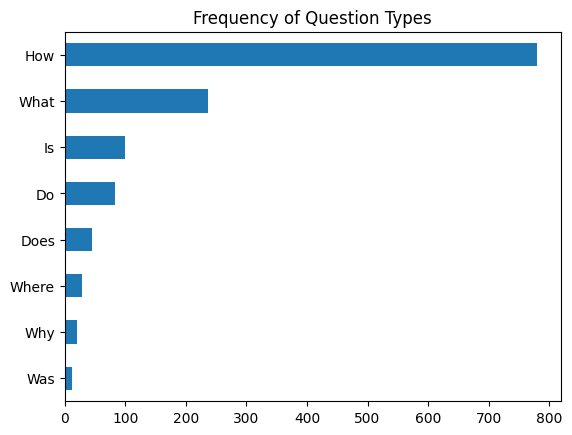

In [9]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()


We can see that questions beginning with "How", "What", and "Is" are the most common ones, so let's have a look at some examples:

In [10]:
for question_type in ["How", "What", "Is"]:
  for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


-----

**Note:** The (question, review, [answer sentences]) format of SubjQA is commonly used in extractive QA datasets, and was pioneered in the Stanford Question Answering Dataset (SQuAD), which was presented in [Rajpurkar et al (2016)](https://arxiv.org/abs/1606.05250). This is a famous dataset that is often used to test the ability of machines to read a passage of text and answer questions about it. The dataset was created by sampling several hundred English articles from Wikipedia, partitioning each article into paragraphs, and then asking crowdworkers to generate a set of questions and answers for each paragraph. In the first version of SQuAD, each answer to a question was guaranteed to exist in the corresponding passage. Bt it wasn't long before sequence models started performing better than humans at extracting the correct span of text with the answer. To make the task more difficult, SQuAD 2.0 was created by agumenting SQuAD 1.1 with a set of adversarial questions that are relevant to a given passage but cannot be answered from the text alone ([Rajpurkar and Liang, 2018](https://arxiv.org/abs/1806.03822)). The state of the art as of mid 2021 is shown in the following figure, with most models since 2019 surpassing human performance

<img src="images_ch7/squad_historical_performance.PNG" title="" alt="" width="500" data-align="center">

However, this superhuman performance does not appear to reflect genuine reading comprehension, since answers to the "unanswerable" questions can usually be identified through patterns in the passages like antonyms. To adress these problems Google released the Natural Questions dataset ([Kwiatkowski, 2019](dx.doi.org/10.1162/tacl_a_00276)), which involves fact-seeking questions obtained from Google search users. The answers in NQ are much longer than in SQuAD and present a more challenging benchmark.

-----

### 7.1.2 - Extracting answers from text

The first thing we'll need for our QA system is to find a way to identify a potential answer as a span of text in a customer review. For example, if we have a question like "Is it waterproof?" and the review passage is "This watch is waterproof at 30m depth", then the model should output "waterproof at 30m". To do this we'll need to understand how to:

* Fram the supervised learning problem
* Tokenize and encode text for QA tasks
* Deal with long passages that exceed a model's maximum context size

#### Span classification

<span style="color:blue">The most common ay to extract answers from text is by framing the problem as a <b>span classification task</b>, where the start and end tokens of an answer span act as the labels that a model needs to predict.</span>

<img src="images_ch7/span_classification.PNG" title="" alt="" width="500" data-align="center">

Since our training set is relatively small, with only 1295 examples, a good strategy is to start with a language model that has already been fine-tuned on a large-scale QA dataset like SQuAD. In general, these models have strong reading comprehension capabilities and serve as a good baseline upon which to build a more accurate system.

This is a somewhat different approach to that taken in previous chapters, where we tipically started with a pretrained model and fine-tuned the task-specific head ourselves. For extractive QA, we can actually start with a fine-tuned model since the structure of the labels remains the same across datasets.

There a more than 400 QA models to choose from in the HuggingFace Hub, so which one should we pick? In general, the answer depends on various factors like wether our corpus is mono- or mulitlingual and the constraints of running the model in a production environment. The following table lists a few models that provide a good foundation to build on:

<img src="images_ch7/qa_models_table.PNG" title="" alt="" width="600" data-align="center">

For the purposes of this chapter, we will use a fine-tuned MiniLM model since it is fast to train and will allow us to quickly iterate on the techniques that we'll be exploring. As usual, the first thing we need is a tokenizer to encode our texts, so let's take a look at how this works for QA tasks.

#### Tokenizing text for QA

To encode our texts, we'll load the [**MiniLM model**](https://huggingface.co/microsoft/Multilingual-MiniLM-L12-H384) ([Wang et al., 2020](https://arxiv.org/abs/2002.10957)) checkpoint from the 🤗 Hub as usual:

In [11]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

To see the model in action, let's first try to extract an answer from a short passage of text. In extractive QA tasks, the inputs are provided as (question, context) pairs, so we pass them both to the tokenizer as follows:

In [12]:
question = "How much music can this hold?"
context = "An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."
inputs = tokenizer(question, context, return_tensors="pt")

In [13]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

The novel thing here is the `token_type_ids` tensor, which indicates which part of the inputs corresponds to the question and context (a 0 indicates a question token, a 1 indicates a context token).

To understand how the tokenizer formats the inputs for QA tasks, let's decode the `input_ids` tensor:

In [14]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


We see that for each QA example, the inputs take the format:

`[CLS] question tokens [SEP] context tokens [SEP]`

where the location of the first [SEP] token is determined by the token_type_ids. Now that our text is tokenized, we just need to instantiate the model with a QA head and run the inputs through the forward pass:

In [15]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Here we can see that we get a `QuestionAnsweringModelOutput` object as the output of the QA head. As previously illustrated, the QA head corresponds to a linear layer that takes the hidden states from the encoder and computes the logits for the start and end spans. This means that we treat QA as a form of token classification, similar to what we encountered for named entity recognition in Chapter 4. To convert the outputs into an answer span, we first need to get the logits for the start and end tokens:

In [18]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [17]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


If we compare the shapes of these logits to the input IDs, we see that there are two logits (a start and end) associated with each input token. As illustrated in the following figure, larger, positive logits correspond to more likely candidates for the start and end tokens. In this example, we can see that the model assigns the highest start token logits to the numbers "1" and "6000", which makes sense since our question is asking about a quantity. Similarly, we see that the end tokens with the highest logits are "minute" and "hours":

<img src="images_ch7/predicted_logits_start_end_tokens.PNG" title="" alt="" width="500" data-align="center">

To get the final answer, we can compute the argmax over the start and end token logits and then slice the span from the inputs. The following code performs these steps and decodes the result so we can print the resulting text:

In [28]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"Question: {question}")
print(f"Context: {context}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Context: An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.
Answer: 6000 hours


In 🤗 Transformers, all of these preprocessing and postprocessing steps are conveniently wrapped in a dedicated pipeline. We can instantiate the pipeline by passing our tokenizer and fine-tuned model as follows:

In [25]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer, device=device)
pipe(question=question, context=context, topk=3)

[{'score': 0.26516246795654297,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.22082947194576263,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253459960222244,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In addition to the answer, the pipeline also returns the model's probability estimate in the `score` field (obtained by taking a softmax over the logits). This is handy when we want to compare multiple answers within a single context. We have also shown that we can have the model predict multiple answers by specifying the `topk` parameter. Sometimes, it is possible to have questions for which no answer is possible, like the empty `answers.answer_start` examples in SubjQA. In these cases the model will assign a high start and end score to the [CLS] token, and the pipeline maps this output to an empty string:

In [26]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.9068408608436584, 'start': 0, 'end': 0, 'answer': ''}

----

**Note:** In our simple example, we obtained the start and end indices by taking the argmax of the corresponding logits. However, this heuristic can produce out-of-scope answers by selecting tokens that belong to the question instead of the context. In practice, the pipeline computes the best combination of start and end indices subject to various constraints such as being in-scope, requiring the start indices to precede the end indices, and so on.

----

#### Dealing with long passages

One subtlety faced by reading comprehension models is that the context often contains more tokens than the maximum sequence length of the model (which is usually a few hundred tokens at most). As illustrated in the following figure, a decent portion of the SubjQA training set contains question-context pairs that won't fit within MiniLM's context size of 512

<img src="images_ch7/context_size_minilm.PNG" title="" alt="" width="500" data-align="center">

For other tasks, like text classification, we usually truncate long texts under the assumption that enough information is contained in the embedding of the [CLS] token to generate accurate predictions. **For QA, however, this strategy is problematic because the answer to a question could lie near the end of the context and thus would be removed by truncation**. The standard way to deal with this is to apply a *sliding window* across the inputs, where each window contains a passage of tokens that fit in the model's context. We can see an example in the following figure, where the first bar corresponds to the question, while the second bar is the context captured in each window

<img src="images_ch7/sliding_window_question.PNG" title="" alt="" width="500" data-align="center">

In 🤗 Transformers, we can set `return_overflowing_tokens=True` in the tokenizer to enable the sliding window. The size of the sliding window is controlled by the `max_seq_length` argument, and the size of the stride is controlled by `doc_stride`. Let's grab the first example from our training set and define a small window to illustrate how this works. In thi case we now get a list of `input_ids`, one for each window. Let's check the number of tokens we have in each window:

In [ ]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(
    example["question"], example["context"],
    return_overflowing_tokens=True, max_length=100, stride=25
)

for idx, window in enumerate(tokenized_example["input_ids"]):
print(f"Window #{idx} has {len(window)} tokens")

We can also see where two windows overlap by decoding the inputs:

In [ ]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

Now that we have some intuition about how QA models can extract answers from text, let's look at the other components we need to build an end-to-end QA pipeline.

### 7.1.3 - Using Haystack to build a QA pipeline

In our simple answer extraction example, we provided both the question and the context to the model. However, in reality our system's users will only provide a question about a product, so we need some way of selecting relevant passages from among all the reviews in our corpus. One way to do this would be to concatenate all the reviews of a given product together and feed them to the model as a single, long context. Although simple, the drawback of this approach is that the context can become extremely long and thereby introduce an unacceptable latency for our users' queries.

For example, let's suppose that on average, each product has 30 reviews and each review takes 100 milliseconds to process. If we need to process all the reviews to get an answer, this would result in an average latency of 3 seconds per user query - much too long for ecommerce websites!

To handle this, modern QA systems are typically based on the **retriever-reader** architecture, which has two main components:

* **Retriever**. Responsible for retrieving relevant documents for a given query. Retrievers are usually categorized as sparse or dense. Sparse retrievers use word frequencies to represent each document and query as a sparse vector. The relevance of a query and a document is then determined by computing an inner product of the vectors. On the other hand, dense retrievers use encoders like transformers to represent the query and document as contextualized embeddings (which are dense vectors). These embeddings encode semantic meaning, and allow dense retrievers to improve search accuracy by understanding the content of the query.

* **Reader**. Responsible for extracting an answer from the documents provided by the retriever. The reader is usually a reading comprehension model, although at the end of the chapter we'll see examples of models that can generate free-form answers.

<img src="images_ch7/retriever_reader_architecture.PNG" title="" alt="" width="500" data-align="center">

To build our QA system, we'll use the [Haystack library](https://haystack.deepset.ai/) developed by deepset, a german company focused on NLP. Haystack is based on the retriever-reader architecture, abstracts much of the complexity involved in building these systems, and integrates tightly with 🤗 Transformers.

In addition to the retriever and reader, there are two more ocmponents involved when building a QA pipeline with Haystack:

* Document store. A document-oriented database that stores documents and metadata which are provided to the retirever at query time.
* Pipeline. Combines all the components of a QA system to enable custom query flows, merging documents from multiple retrievers and more.

We'll first look at how we can use these components to quickly build a prototype QA pipeline. Later, we'll examine how we can improve its performance.

#### Initializing a document store

In Haystack, there are various document stores to choose from and each one can be paired with a dedicated set of retrievers. This is illustrated in the following table, where the compatibility of sparse (TF-IDF, BM25) and dense (Embedding, DPR) retrievers is shown for each of the avalable document stores. We'll explain what all these acronyms mean later in this chapter.

<img src="images_ch7/haystack_retrievers_compatibility.PNG" title="" alt="" width="350" data-align="center">

Since we'll be exploring both sparse and dense retrievers in this chapter, we'll use the `ElasticSearchDocumentStore`, which is compatible with both retriever types. Ealstic-search is a search engine that is capable of handling a diverse range of data types, including textual, numerical, geospatial, structured, and unstructured. It ability to store huge volumes of data and quickly filter it with full-text search features makes it especially well suited for developing QA systems. It also has the advantage of being the industry standard for infraestructure analytics, so there is a good chance you work/end up working in a company that already has a cluster you can work with.

To initialize the document store, we first need to download and install Elasticsearch. By following Elasticsearch's guide, we can grab the latest release for Linux with `wget` and unpack it with the `tar` shell command:

In [ ]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

Next we need to start the Elasticsearch server. Since we are running all the code in this book within Jupyter notebooks, we'll need to use Python's `Popen()` function to spawn a new process. While we're at it, let's also run the subprocess in the background using the `chown` shell command:

In [ ]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))

# Wait until Elasticsearch has started
!sleep 30

In the `Popen()` function, the `args` specify the program we wish to execute, while `stdout=PIPE` creates a new pipe for the standard output and `stderr=STDOUT` collects the errors in the same pipe. The `preexec_fn` argument specifies the ID of the subprocess we wish to use. By default, Elasticsearch runs locally on port 9200, so we can test the connection by sending an HTTP request to localhost:

In [ ]:
!curl -X GET "localhost:9200/?pretty"

Now that our Elasticsearch server is up and running, the next thing to do is instantialate the document store:

In [ ]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

By default, `ElasticsearchDocumentStore` creates two indices on Elasticsearch: one called `document` for (you guessed it) storing documents, and another called `label` for storing the annotated answer spans. For now, we'll just populate the `document` index with the SubjQA reviews, and Haystack's document stores expect a list of dictionaries with `text` and `meta` keys as follows:

```
{
    "text": "<the-context>",
    "meta": {
        "field_01": "<additional-metadata>",
        "field_02": "<additional-metadata>",
    ...
    }
}
```

the fileds in `meta` cane be used for applying filters during retrieval. For our purposes we'll include the item_id and q_review_id columns of SubjQA so we can filter by product and question ID, along with the corresponding training split. We can then loop through the examples in each `DataFrame` and add them to the index with the `write_documents()` method as follows:

In [ ]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
            for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Great, we have loaded all our reviews into an index! To search the index we'll need a retriever, so let's look at how can initialize one for Elasticsearch

#### Initializing a retriever

The Elasticsearch document store can be paired with any of the Haystack retrievers, so let's start by using a sparse retriever based on BM25 (short for "Best Match 25"). BM25 is an improved version of the classic Term Frequency-Inverse Document Frequency (TF-IDF) algorithm and represents the question and context as sparse vectors that can be searched efficiently on Elasticsearch. The BM25 score measures how much matched text is about a search query and improves on TF-IDF by saturating TF values quickly and normalizing the document length so that short documents are favored over long ones.

----

**Note:** For an in-depth explanation of document scoring with TF-IDF and BM25 see Chapter 23 of [Speech and Language Processing, 3rd edition, by D. Jurafsky and J.H. Martin (Prentice Hall)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf).

----

In Haystack, the BM25 retriever is used by default in ElasticsearchRetriever, so let's initialize this class by specifying the document store we wish to search over:

In [ ]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

Next, let's look at a simple query for a single electronics product in the training set. For review-based QA systems like ours, it's important to restrict the queries to a single item because otherwise the retriever would source reviews about products that are not related to a user’s query. For example, asking “Is the camera quality any good?” without a product filter could return reviews about phones, when the user might be asking about a specific laptop camera instead. By themselves, the ASIN values in our dataset are a bit cryptic, but we can decipher them with online tools like [amazon ASIN](https://amazon-asin.com/) or by simply appending the value of item_id to the [www.amazon.com/dp/](www.amazon.com/dp/) URL. The following item ID corresponds to one of Amazon's Fire tablets, so let's use the retriever's `retrieve()`

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

Here we have specified how many documents to return with the top_k argument and applied a filter on both the item_id and split keys that were included in the meta field of our documents. Each element of `retrieved_docs` in a Haystack `Document` object that is used to represent documents and includes the retriever's query score along with other metadata. Let's have a look at one of the retrieved documents:

In [ ]:
print(retrieved_docs[0])

In addition to the document's text, we can see the `score` that Elasticsearch computed for its relevance to the query (larger scores imply a better match). Under the hood, Elasticsearch relies on [Lucene](https://lucene.apache.org/) for indexing and search, so by default it uses Lucene's *practical scoring function*. You can find the nitty-gritty details behind the scoring function in the [Elasticsearch documentation](https://www.elastic.co/guide/en/elasticsearch/guide/current/practical-scoring-function.html), but in brief terms in first filters the candidate documents by applying a Boolean test (does the document match the query?), and then applies a similarity metric that's based on representing both the document and the query as vectors.

Now that we have a way to retrieve relevant documents, the next thing we need is a way to extract answers from them. This is where the reader comes in, so let's take a look at how we can load our MiniLM model in Haystack.

#### Initializing a reader

In Haystack, there are two types of readers one can use to extract answers from a given context:

* `FARMReader`. Based on deepset's [FARM framework](https://farm.deepset.ai/) for fine-tuning and deploying transformers. Compatible with models trained using 🤗 Transformers and can load models directly from the Hugging Face Hub.

* `TransformersReader`. Based on the QA pipeline from Transformers. Suitable for running inference only.

Although both readers handle a model's weights in the same way, there are some differences in the way the predicitons are converted to produce answers:

* In 🤗 Transformers, the QA pipeline normalizes the start and end logits with a softmax in each passage. This means that it is only meaningful to compare answer scores between answers extracted from the same passage, where the probabilities sum to 1. For example, an answer score of 0.9 from one passage is not necessarily better than a score of 0.8 in another. In FARM, the logits are not normalized, so inter-passage answers can be compared more easily.

* The `TransformersReader` sometimes predicts the same answer twice, but with different scores. This can happen in long contexts if the answer lies across two overlapping windows. In FARM, these duplicates are removed.

Since we will be fine-tuning the reader later in the chapter, we'll use the `FARMReader`. As with Transformers, to load the model we just need to specify the MiniLM checkpoint on the Hugging Face Hub along with some QA-specific arguments:

In [ ]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False, max_seq_len=max_seq_length, doc_stride=doc_stride, return_no_answer=True)

In `FARMReader`, the behaviour of the sliding window is controlled by the same max_sq_length and doc_stride arguments that we saw for the tokenizer. Here we have used the values from the MiniLM paper. To confirm, let's now test the reader on our simple example from earlier:

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

Great, the reader appears to be working as expected—so next, let’s tie together all our components using one of Haystack’s pipelines.

#### Putting it all together

Haystack provides a `Pipeline` abstraction that allows us to combine retrievers, readers, and other components together as a graph that can be easily customized for each use case. There are also predefined pipelines analogous to those in 🤗 Transformers, but specialized for QA systems. In our case, we are interested in extracting answers, so we'll use the `ExtractiveQAPipeline`, which takes a single retriever-reader pair as its arguments:

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

Each `Pipeline` has a `run()` method that specifies how the query flow should be executed. For the `ExtractiveQAPipeline` we just need to pass the `query`, the number of documents to retrieve with `top_k_retriever`, and the number of answers to extract from these documents with `top_k_reader`. In our case, we also need to specify ta filter over the item ID which can be done using the `filters` argument as we did with the retriever earlier. Let's run a simple example using our question about the Amazon Fire tablet again, but this time returning the extracted answers:

In [ ]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers, filters={"item_id": [item_id], "split":["train"]})
print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

Great, we now have an end-to-end QA system for Amazon product reviews! This is a good start, but notice that compared to the first answer returned by the system, the second and third answers are closer to what the question is actually asking. To do better, we'll need some metrics to quantify the performance of the retriever and reader. We'll take a look at that next.

## 7.2 - Improving our QA pipeline

Although much of the recent research on QA has fcoused on improving reading comprehension models, in practice it doesn't matter how good your reader is if the retriever can't find the relevant documents in the first place! In particular, the retriever sets an upper bound on the performance of the whole QA system, so it's important to make sure it's doing a good job. With this in mind, let's start by introducing some common metrics to evaluate the retriever so that we can compare the performance of sparse and dense representations.

### 7.2.1 - Evaluating the retriever

A common metric for evaluating retrievers is **recall**, which measures the fraction of all relevant documents that are retrieved. In this context, relevant simply means whether the answer is present in a passage of text or not, so given a set of questions, we can compute recall by counting the number of times an answer appears in the top $k$ documents returned by the retriever.

In Haystack, there are two ways to evaluate retrievers:

* Use the retriever's in-built `eval()` method. This can be used for both open- and closed-domenain QA, but for datasets like SubjQA where each document is paired with a single product and we need to filter by product ID for every query.

* Build a custom `Pipeline` that combines a retriever with the `EvalRetriever` class. This enables the implementation of custom metrics and query flows.

-----

**Note:** A complementary metric to recall is mean *average precision* (mAP), which rewards retrievers that can place the correct answers higher up in the document ranking.

-----

Since we need to evaluate the recall per product and then aggregate across all products, we'll opt for the second approach. Each node in the Pipeline graph represents a class that takes some inputs and produces some outputs via a run method:

```python
class PipelineNode:
    
def __init__(self):
    self.outgoing_edges = 1

def run(self, **kwargs):
    ...
    return (outputs, "outgoing_edge_name")
```

Here `kwargs` corresponds to the outputs from the previous node in the graph, which is manipulated within the `run()` method to return a tuple of the outputs for the next node, along with a name for the outgoing edge. The only other requirement is to include an outgoing_edges attribute that indicates the number of outputs from the node (in most cases `outgoing_edges=1`, unless you have branches in the pipeline that route the inputs according to some criterion).

In our case, we need a node to evaluate the retriever, so we'll use the `EvalRetriever` class whose `run()` method keeps track of which documents have answers that match the ground truth. With this class we can then build up a `Pipeline` graph by adding the evaluation node after a node that represents the retriever itself:



In [ ]:
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever", inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever", inputs=["ESRetriever"])
        self.pipeline = pipe

pipe = EvalRetrieverPipeline(es_retriever)

Notice that each node is given a `name` and a list of `inputs`. In most cases, each node has a single outgoing edge, so we just need to include the name of the previous node in `inputs`.

Now that we have our evaluation pipeline, we need to pass some queries and their corresponding answers. To do this, we'll add the answers to a dedicated `label` index on our document store. Haystack provides a `Label` object that represents the answer spans and their metadata in a standardized fashion. To populate the `label` index, we'll first create a list of `Label` objects by looping over each question in the test set and extracting the matching answers and additional metadata:

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})  
        labels.append(label)

If we peek at one of these labels:

In [ ]:
print(labels[0])